# Language Modeling Lab

---
## 1. Notebook Overview

### 1.1 Why language modeling?
Language models estimate how plausible a sequence of tokens is. We need them to score text, compare generations, and prepare for downstream tasks such as machine translation or speech recognition.

### 1.2 What you will build
- reuse the cleaned tweet corpus from Lab 2
- implement unigram and bigram language models with Laplace smoothing
- evaluate both models on held-out data with perplexity
- interpret the learned distributions and compare them to NLTK baselines

### 1.3 Section roadmap
1. `Section 2` loads the preprocessed corpus and defines reusable helpers.
2. `Section 3` implements custom unigram and bigram models in log-space.
3. `Section 4` evaluates the models with perplexity on a test split.
4. `Section 5` inspects frequent and rare n-grams to understand model behaviour.
5. `Section 6` (optional) validates our implementation against NLTK's reference models.

## 2.  Corpus Preparation & Utilities

### 2. 1 Goal
Reuse the preprocessed tweets from Lab 2 and provide helper functions so that every subsequent experiment works with consistent tokenization.

### 2.2 Steps in this section
1. Load the preprocessed training dataset from `../Data/multi_label/tweets_preprocessed_train.parquet`. 
2. Load the preprocessed test dataset from `../Data/multi_label/tweets_preprocessed_test.parquet` (consistent with Lab 4/5).
3. Convert each tweet into a token list that our models can consume.
4. Define helper utilities (`train_test_split_corpus`, `ensure_tokens`) that standardise splitting and token handling across the notebook. 

### 2.3 Why this matters
Using the same train/test splits as Lab 4 and Lab 5 ensures that results are comparable across all labs. This consistency is critical for evaluating and comparing different NLP approaches on identical data partitions.

In [1]:
import math
from collections import Counter, defaultdict
from typing import List, Sequence, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


# Path constants for train and test data (consistent with Lab 4/5)
TRAIN_DATA_PATH = "../Data/multi_label/tweets_preprocessed_train.parquet"
TEST_DATA_PATH = "../Data/multi_label/tweets_preprocessed_test.parquet"
RANDOM_STATE = 42


Corpus = List[List[str]]  # type alias for readability


def load_corpus(path: str) -> Corpus:
    """Return tokenized sentences from the preprocessed parquet exported in Lab 2."""
    df_preprocessed = pd. read_parquet(path)
    corpus = [str(tweet). split() for tweet in df_preprocessed["text"]]
    if not corpus:
        raise ValueError("The corpus is empty.  Did preprocessing export any sentences?")
    return corpus


def train_test_split_corpus(
    corpus: Sequence[Sequence[str]],
    test_size: float = 0.2,
    random_state: int = RANDOM_STATE,
) -> Tuple[Corpus, Corpus]:
    """Split corpus into train/test partitions using sklearn's helper.
    
    Note: This function is kept for documentation and potential ad-hoc experiments.
    For the main evaluation, we use the preprocessed test data from Lab 2 to ensure
    consistency with Lab 4 and Lab 5.
    """
    train, test = train_test_split(
        corpus, test_size=test_size, random_state=random_state
    )
    return [list(sent) for sent in train], [list(sent) for sent in test]


def ensure_tokens(sentence: Union[Sequence[str], str]) -> List[str]:
    """Convert a whitespace separated string or an iterable of tokens into a token list."""
    if isinstance(sentence, str):
        sentence = sentence.split()
    return list(sentence)


# Load train and test corpora from preprocessed parquet files (consistent with Lab 4/5)
train_corpus = load_corpus(TRAIN_DATA_PATH)
test_corpus = load_corpus(TEST_DATA_PATH)
print(f"Loaded {len(train_corpus)} training sentences from {TRAIN_DATA_PATH}")
print(f"Loaded {len(test_corpus)} test sentences from {TEST_DATA_PATH}")
if train_corpus:
    print("Example tokens:", train_corpus[0][:10])

Loaded 5465 training sentences from ../Data/multi_label/tweets_preprocessed_train.parquet
Loaded 1511 test sentences from ../Data/multi_label/tweets_preprocessed_test.parquet
Example tokens: ['lumber', 'beat', 'rapid', 'game', 'western', 'division', 'final', 'evan', 'edwards', 'hit']


## 3. Custom N-gram Language Models

### 3.1 Why start with unigrams and bigrams?
Unigrams capture individual word preferences while bigrams add short-range context. Together they form the foundation for more complex n-gram models and help us reason about smoothing and sparsity.

### 3.2 Implementation notes
We implement reusable Python classes that count tokens, apply Laplace smoothing, and return log probabilities. Working in log-space prevents numerical underflow and makes sentence scoring additive.

### 3.3 Quick diagnostic prints
After defining both classes we instantiate them on the training split and inspect example log-probabilities/perplexities to verify that counts and smoothing behave as expected.

In [2]:
class UnigramLM:
    """Laplace-smoothed unigram language model operating in log-space."""

    def __init__(self, corpus: Sequence[Sequence[str]]):
        self.unigram_counts = Counter()
        self.total_tokens = 0
        self.vocab = set()

        for sentence in corpus:
            tokens = ensure_tokens(sentence)
            self.unigram_counts.update(tokens)
            self.total_tokens += len(tokens)
            self.vocab.update(tokens)

        if self.total_tokens == 0:
            raise ValueError("Cannot train a UnigramLM on an empty corpus.")

        self.vocab_size = len(self.vocab)

    def log_prob(self, word: str) -> float:
        """Return log P(word) with add-one (Laplace) smoothing."""
        count = self.unigram_counts.get(word, 0)
        return math.log((count + 1) / (self.total_tokens + self.vocab_size))

    def sentence_log_prob(self, sentence: Union[Sequence[str], str]) -> float:
        """Return the log probability of a sentence represented by tokens or text."""
        tokens = ensure_tokens(sentence)
        if not tokens:
            return float("-inf")
        return sum(self.log_prob(token) for token in tokens)


In [3]:
class BigramLM:
    """Laplace-smoothed bigram language model operating in log-space."""

    def __init__(self, corpus: Sequence[Sequence[str]]):
        self.bigram_counts = defaultdict(Counter)
        self.unigram_counts = Counter()
        self.vocab = set()

        for sentence in corpus:
            tokens = ensure_tokens(sentence)
            prev_word = None
            for word in tokens:
                self.unigram_counts[word] += 1
                self.vocab.add(word)
                if prev_word is not None:
                    self.bigram_counts[prev_word][word] += 1
                prev_word = word

        self.vocab_size = len(self.vocab)
        self.total_tokens = sum(self.unigram_counts.values())
        if self.total_tokens == 0:
            raise ValueError("Cannot train a BigramLM on an empty corpus.")

    def log_prob(self, prev_word: str, word: str) -> float:
        """Return log P(word | prev_word) with add-one (Laplace) smoothing."""
        bigram_count = self.bigram_counts[prev_word].get(word, 0)
        unigram_count = self.unigram_counts.get(prev_word, 0)
        return math.log((bigram_count + 1) / (unigram_count + self.vocab_size))

    def sentence_log_prob(self, sentence: Union[Sequence[str], str]) -> float:
        """Return the log probability of a sentence represented by tokens or text."""
        tokens = ensure_tokens(sentence)
        if not tokens:
            return float("-inf")

        first_word = tokens[0]
        log_prob = math.log(
            (self.unigram_counts.get(first_word, 0) + 1)
            / (self.total_tokens + self.vocab_size)
        )

        for prev_word, word in zip(tokens, tokens[1:]):
            log_prob += self.log_prob(prev_word, word)
        return log_prob


In [4]:
# Train and test corpora are already loaded from preprocessed parquet files above
print(f"Train sentences: {len(train_corpus)} | Test sentences: {len(test_corpus)}")

# Train custom language models on the training data
uni_lm = UnigramLM(train_corpus)
bi_lm = BigramLM(train_corpus)

print("=== CUSTOM MODELS TRAINED ===")
print("Unigram vocabulary size:", uni_lm.vocab_size)
print("Bigram vocabulary size:", bi_lm.vocab_size)

sample_sentences = [
    "happy new year",
    "good morning world",
    "love play music",
    "game love music",
    "watch great game",
]

diagnostics = []
for sentence in sample_sentences:
    tokens = ensure_tokens(sentence)
    unigram_log = uni_lm.sentence_log_prob(tokens)
    bigram_log = bi_lm.sentence_log_prob(tokens)
    unigram_ppl = np.exp(-unigram_log / max(len(tokens), 1))
    bigram_ppl = np.exp(-bigram_log / max(len(tokens), 1))
    diagnostics.append(
        {
            "sentence": sentence,
            "unigram_log_prob": unigram_log,
            "unigram_perplexity": unigram_ppl,
            "bigram_log_prob": bigram_log,
            "bigram_perplexity": bigram_ppl,
        }
    )

diag_df = pd.DataFrame(diagnostics)
print("\nSample sentence diagnostics (higher log-prob & lower perplexity = better)")
print(
    diag_df.to_string(
        index=False,
        formatters={
            "unigram_log_prob": lambda x: f"{x:.4f}",
            "unigram_perplexity": lambda x: f"{x:.2f}",
            "bigram_log_prob": lambda x: f"{x:.4f}",
            "bigram_perplexity": lambda x: f"{x:.2f}",
        },
    )
)

print("\nNote: Bigram perplexities are typically lower because conditional probabilities incorporate short-range context.")


Train sentences: 5465 | Test sentences: 1511
=== CUSTOM MODELS TRAINED ===
Unigram vocabulary size: 13316
Bigram vocabulary size: 13316

Sample sentence diagnostics (higher log-prob & lower perplexity = better)
          sentence unigram_log_prob unigram_perplexity bigram_log_prob bigram_perplexity
    happy new year         -16.2283             223.51        -17.7205            367.55
good morning world         -17.5118             342.84        -22.4355           1769.60
   love play music         -16.6313             255.64        -22.7119           1940.37
   game love music         -16.2002             221.42        -21.9750           1517.77
  watch great game         -16.6847             260.23        -21.6063           1342.26

Note: Bigram perplexities are typically lower because conditional probabilities incorporate short-range context.


## 4. Model Evaluation with Perplexity

### 4.1 Why perplexity?
Perplexity summarises how well a language model predicts unseen data. Lower values indicate that the model assigns higher probability to the held-out corpus.

### 4.2 How we evaluate
- reuse the train/test split to avoid data leakage
- compute sentence log-probabilities with each model
- aggregate them into corpus-level perplexity scores and visualise the comparison

=== HELD-OUT EVALUATION ===
Perplexity summarises predictive quality on the 20% test split (lower is better).
Perplexity (unigram): 3998.41
Perplexity (bigram): 8951.62

--- Perplexity Comparison ---
Unigram Perplexity: 3998.41
Bigram Perplexity:  8951.62
------------------------------
Interpretation: The unigram model generalises better on the held-out data.


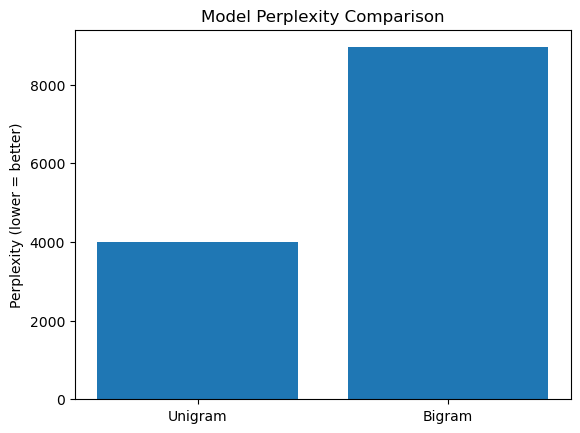

In [5]:
def compute_perplexity(
    model, corpus: Sequence[Sequence[str]], model_label: str
) -> float:
    """Compute corpus-level perplexity for the provided language model."""
    total_log_prob = 0.0
    token_count = 0

    for sentence in corpus:
        tokens = ensure_tokens(sentence)
        if not tokens:
            continue
        total_log_prob += model.sentence_log_prob(tokens)
        token_count += len(tokens)

    if token_count == 0:
        raise ValueError("Cannot compute perplexity on an empty corpus.")

    perplexity = np.exp(-total_log_prob / token_count)
    print(f"Perplexity ({model_label}): {perplexity:.2f}")
    return perplexity


print("=== HELD-OUT EVALUATION ===")
print("Perplexity summarises predictive quality on the 20% test split (lower is better).")
uni_perp = compute_perplexity(uni_lm, test_corpus, model_label="unigram")
bi_perp = compute_perplexity(bi_lm, test_corpus, model_label="bigram")

print("\n--- Perplexity Comparison ---")
print(f"Unigram Perplexity: {uni_perp:.2f}")
print(f"Bigram Perplexity:  {bi_perp:.2f}")
print("-" * 30)

better = "bigram" if bi_perp < uni_perp else "unigram"
print(f"Interpretation: The {better} model generalises better on the held-out data.")

models = ["Unigram", "Bigram"]
values = [uni_perp, bi_perp]

plt.bar(models, values)
plt.title("Model Perplexity Comparison")
plt.ylabel("Perplexity (lower = better)")
plt.show()


## 5. Exploring Learned N-grams

### 5.1 Why inspect counts and probabilities?
Frequency tables reveal what the model has memorised and whether smoothing behaves as expected for rarely observed events.

### 5.2 What we analyse
- the top unigrams from the training data
- the most likely continuations for a chosen history (e.g., `love → ?`)
- probabilities assigned to unseen bigrams to confirm Laplace smoothing

In [6]:
# Top N most frequent unigrams in the training data
n = 20
print(f"\nTop {n} most frequent unigrams (training split)")
for word, count in uni_lm.unigram_counts.most_common(n):
    print(f"{word:<10} -> count: {count}")

sample_prev = "love"
top_bigrams = bi_lm.bigram_counts[sample_prev].most_common(10)

print(f"\nTop 10 bigrams starting with '{sample_prev}' (training split)")
for word, count in top_bigrams:
    prob = np.exp(bi_lm.log_prob(sample_prev, word))
    print(f"{sample_prev} {word:<10} -> count: {count}, P({word}|{sample_prev}) = {prob:.5f}")

print("\nExample of Laplace smoothing on an unseen bigram")
unseen = ("love", "banana")
print(f"P({unseen[1]}|{unseen[0]}) = {np.exp(bi_lm.log_prob(*unseen)):.8f} (non-zero due to smoothing)")



Top 20 most frequent unigrams (training split)
new        -> count: 537
day        -> count: 456
love       -> count: 447
good       -> count: 417
game       -> count: 393
watch      -> count: 373
year       -> count: 359
time       -> count: 357
music      -> count: 350
happy      -> count: 310
like       -> count: 299
come       -> count: 295
win        -> count: 287
live       -> count: 285
go         -> count: 279
video      -> count: 277
red        -> count: 266
heart      -> count: 265
great      -> count: 258
play       -> count: 255

Top 10 bigrams starting with 'love' (training split)
love song       -> count: 11, P(song|love) = 0.00087
love love       -> count: 9, P(love|love) = 0.00073
love red        -> count: 9, P(red|love) = 0.00073
love thank      -> count: 7, P(thank|love) = 0.00058
love guy        -> count: 6, P(guy|love) = 0.00051
love new        -> count: 5, P(new|love) = 0.00044
love fake       -> count: 5, P(fake|love) = 0.00044
love one        -> count: 4, P(one|

## 6. Optional: External Baseline with NLTK

### 6.1 Why compare with NLTK?
Validating against a well-tested library helps confirm that our implementation is correct and highlights the effect of different smoothing strategies.

> *Skip this section if you only need the custom models. The notebook remains functional without executing Section 6.*

In [7]:
from nltk.lm import MLE, Laplace
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.util import ngrams

### 6.2 Train NLTK MLE and Laplace models
We reuse the training corpus, lowercase tokens for library compatibility, and fit both Maximum Likelihood (no smoothing) and Laplace-smoothed versions using `nltk.lm`.

In [8]:
# --- Prepare NLTK models ---
n = 2  # Bigram
# Lowercase all tokens for consistency
train_corpus_lower = [[w.lower() for w in sent] for sent in train_corpus]

# --- Unigram models ---
train_data_uni, vocab_uni = padded_everygram_pipeline(1, train_corpus_lower)

# MLE model
nltk_uni_mle = MLE(1)
nltk_uni_mle.fit(train_data_uni, vocab_uni)

# Laplace-smoothed model
train_data_uni, vocab_uni = padded_everygram_pipeline(1, train_corpus_lower)  # re-generate generator
nltk_uni_laplace = Laplace(1)
nltk_uni_laplace.fit(train_data_uni, vocab_uni)

# --- Bigram models ---
train_data_bi, vocab_bi = padded_everygram_pipeline(n, train_corpus_lower)

# MLE bigram
nltk_bigram_mle = MLE(n)
nltk_bigram_mle.fit(train_data_bi, vocab_bi)

# Laplace bigram
train_data_bi, vocab_bi = padded_everygram_pipeline(n, train_corpus_lower)  # re-generate generator
nltk_bigram_laplace = Laplace(n)
nltk_bigram_laplace.fit(train_data_bi, vocab_bi)

print("NLTK MLE and Laplace models trained.")

NLTK MLE and Laplace models trained.


### 6.3 Compare n-gram statistics
We align our custom estimates with the NLTK models to check that probabilities and rankings match after smoothing.

In [9]:
# --- Probability comparison across models ---
import math

# Unigram comparison table
num_items = 10
unigram_rows = []
for word, count in uni_lm.unigram_counts.most_common(num_items):
    unigram_rows.append(
        {
            "word": word,
            "custom_count": count,
            "custom_prob": math.exp(uni_lm.log_prob(word)),
            "nltk_mle_prob": nltk_uni_mle.score(word.lower(), []),
            "nltk_laplace_prob": nltk_uni_laplace.score(word.lower(), []),
        }
    )

float_fmt = lambda x: f"{x:.6f}"
unigram_df = pd.DataFrame(unigram_rows)
print(f"Top {num_items} unigram probabilities (custom vs. NLTK)")
print(unigram_df.to_string(index=False, float_format=float_fmt))

# Bigram comparison table
sample_prev = "love"
num_bigrams = 10
conditional_counts = bi_lm.bigram_counts.get(sample_prev, [])

if not conditional_counts:
    print(f"No bigrams found starting with '{sample_prev}'.")
else:
    bigram_rows = []
    for word, count in conditional_counts.most_common(num_bigrams):
        bigram_rows.append(
            {
                "bigram": f"{sample_prev} {word}",
                "custom_count": count,
                "custom_prob": math.exp(bi_lm.log_prob(sample_prev, word)),
                "nltk_mle_prob": nltk_bigram_mle.score(word.lower(), [sample_prev.lower()]),
                "nltk_laplace_prob": nltk_bigram_laplace.score(word.lower(), [sample_prev.lower()]),
            }
        )

    bigram_df = pd.DataFrame(bigram_rows)
    print("\nTop {} bigram probabilities given '{}'".format(num_bigrams, sample_prev))
    print(bigram_df.to_string(index=False, float_format=float_fmt))

print("\nInterpretation: Matching probabilities between our custom models and NLTK confirms that counting and smoothing behave identically.")


Top 10 unigram probabilities (custom vs. NLTK)
 word  custom_count  custom_prob  nltk_mle_prob  nltk_laplace_prob
  new           537     0.006141       0.007228           0.006141
  day           456     0.005216       0.006137           0.005216
 love           447     0.005113       0.006016           0.005113
 good           417     0.004771       0.005613           0.004771
 game           393     0.004497       0.005290           0.004497
watch           373     0.004269       0.005020           0.004269
 year           359     0.004109       0.004832           0.004109
 time           357     0.004086       0.004805           0.004086
music           350     0.004006       0.004711           0.004006
happy           310     0.003550       0.004172           0.003550

Top 10 bigram probabilities given 'love'
     bigram  custom_count  custom_prob  nltk_mle_prob  nltk_laplace_prob
  love song            11     0.000872       0.024609           0.000872
  love love             9   

### 6.4 Key observations from the comparison
- Custom and NLTK MLE probabilities line up for frequent items, confirming our counting logic.
- Laplace smoothing consistently lowers probabilities because it reserves mass for unseen events.
- Discrepancies highlight where text casing or tokenisation differs; adjust preprocessing if a certain analysis requires strict comparability.

### 6.5 Sentence-level log-probability comparison
We compare sentence scores across custom and NLTK models to see how smoothing affects longer sequences. Large gaps between MLE and Laplace highlight how aggressively smoothing redistributes probability mass.

=== Sentence-level log-probabilities across models ===
Zero probabilities in the MLE models appear as -inf log-values and infinite perplexities.
          sentence custom_uni_log custom_uni_ppl custom_bi_log custom_bi_ppl nltk_uni_mle_log nltk_uni_lap_log nltk_bi_mle_log nltk_bi_lap_log
    happy new year         -16.23         223.51        -17.72        367.55             -inf           -38.99          -11.17          -22.97
good morning world         -17.51         342.84        -22.44       1769.60             -inf           -40.27            -inf          -30.19
   love play music         -16.63         255.64        -22.71       1940.37             -inf           -39.39            -inf          -29.61
   game love music         -16.20         221.42        -21.97       1517.77             -inf           -38.96          -18.48          -29.58
  watch great game         -16.68         260.23        -21.61       1342.26             -inf           -39.45          -16.24          -27.

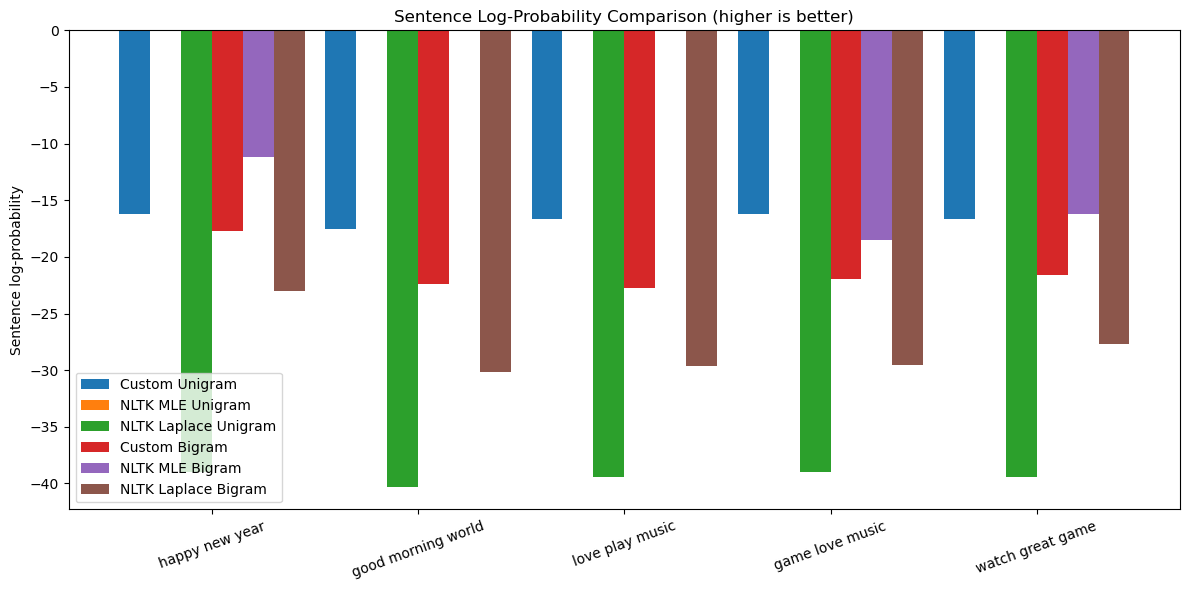


Observation: Laplace-smoothed models avoid -inf scores by assigning non-zero probability mass to unseen tokens, which keeps their perplexities finite.


In [10]:
models = ['Custom Unigram', 'NLTK MLE Unigram', 'NLTK Laplace Unigram',
          'Custom Bigram', 'NLTK MLE Bigram', 'NLTK Laplace Bigram']

sentence_labels = sample_sentences
results = []

print("=== Sentence-level log-probabilities across models ===")
print("Zero probabilities in the MLE models appear as -inf log-values and infinite perplexities.")

for sentence in sentence_labels:
    tokens = ensure_tokens(sentence)
    token_count = len(tokens)
    tokens_lower = [token.lower() for token in tokens]

    # Custom models
    uni_log = uni_lm.sentence_log_prob(tokens)
    bi_log = bi_lm.sentence_log_prob(tokens)

    # Helper to accumulate log probabilities from NLTK models
    def nltk_sentence_log_prob(model, n, lowered_tokens):
        padded = ["<s>"] + lowered_tokens + ["</s>"]
        ngram_list = list(ngrams(padded, n))
        total = 0.0
        for gram in ngram_list:
            context = list(gram[:-1])
            prob = model.score(gram[-1], context)
            if prob <= 0:
                return float('-inf')
            total += np.log(prob)
        return total

    nltk_uni_mle_log = nltk_sentence_log_prob(nltk_uni_mle, 1, tokens_lower)
    nltk_uni_lap_log = nltk_sentence_log_prob(nltk_uni_laplace, 1, tokens_lower)
    nltk_bi_mle_log = nltk_sentence_log_prob(nltk_bigram_mle, 2, tokens_lower)
    nltk_bi_lap_log = nltk_sentence_log_prob(nltk_bigram_laplace, 2, tokens_lower)

    def log_to_perplexity(log_val):
        if not np.isfinite(log_val):
            return float('inf')
        return np.exp(-log_val / max(token_count, 1))

    results.append(
        {
            "sentence": sentence,
            "custom_uni_log": uni_log,
            "custom_uni_ppl": log_to_perplexity(uni_log),
            "custom_bi_log": bi_log,
            "custom_bi_ppl": log_to_perplexity(bi_log),
            "nltk_uni_mle_log": nltk_uni_mle_log,
            "nltk_uni_lap_log": nltk_uni_lap_log,
            "nltk_bi_mle_log": nltk_bi_mle_log,
            "nltk_bi_lap_log": nltk_bi_lap_log,
        }
    )

results_df = pd.DataFrame(results)
formatters = {col: (lambda x: f"{x:.2f}" if np.isfinite(x) else "-inf" if x == float('-inf') else "inf")
              for col in results_df.columns if col != 'sentence'}
print(results_df.to_string(index=False, formatters=formatters))

avg_perps = results_df[["custom_uni_ppl", "custom_bi_ppl"]].replace(np.inf, np.nan).mean()
if avg_perps.isnull().all():
    print("\nMean perplexities could not be computed due to infinite values (typically from zero-probability sentences).")
else:
    print("\nAverage perplexities across sample sentences:")
    for model_name, value in avg_perps.items():
        print(f"  {model_name}: {value:.2f}")

# Prepare data for visual comparison (replace -inf with NaN to avoid plotting issues)
plot_matrix = results_df[[
    "custom_uni_log", "nltk_uni_mle_log", "nltk_uni_lap_log",
    "custom_bi_log", "nltk_bi_mle_log", "nltk_bi_lap_log"
]].replace(-np.inf, np.nan).values

x = np.arange(len(sentence_labels))
width = 0.15

fig, ax = plt.subplots(figsize=(12, 6))
for i in range(len(models)):
    ax.bar(x + i * width, plot_matrix[:, i], width, label=models[i])

ax.set_xticks(x + 2.5 * width)
ax.set_xticklabels(sentence_labels, rotation=20)
ax.set_ylabel('Sentence log-probability')
ax.set_title('Sentence Log-Probability Comparison (higher is better)')
ax.legend()
plt.tight_layout()
plt.show()

print("\nObservation: Laplace-smoothed models avoid -inf scores by assigning non-zero probability mass to unseen tokens, which keeps their perplexities finite.")
